# Building a Transformer From Scratch

### Authors:
 - Carla Ellefsen
 - Brendan McKinley
 - Diya Vinod
 - Bingshen Lu
 - Michael Ivanitskiy

In [13]:
from dataclasses import dataclass
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from jaxtyping import Float, Int
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import Optional, List
import matplotlib.pyplot as plt
import re
import os
import math
from tokenizers import Tokenizer, models, pre_tokenizers, trainers

## Transformer

In [14]:
@dataclass
class GPTConfig:
    # default test values -- too small for a real language model, but big enough for testing
    d_vocab: int = 10_000  # size of the vocabulary
    d_model: int = 128  # dimension of the model
    d_mlp: int = 512  # dimension of the MLP (Feed-Forward) layer
    n_heads: int = 4  # number of attention heads
    d_head: int = 32  # dimension of each attention head
    n_layers: int = 6  # number of layers in the transformer
    act_fn: type[nn.Module] = nn.ReLU  # activation function

    @property
    def n_params(self) -> tuple[int]:
        "an estimate of the number of parameters"
        return (
            self.d_vocab * self.d_model  # embeddings (and tied unembeddings)
            + (
                self.d_model * self.d_mlp * 2  # mlp weights
                + self.d_model + self.d_mlp  # mlp bias
                + self.n_heads * (  # number of heads
                    4 * self.d_model * self.d_head  # 4 because Q, K, O, V
                )
            ) * self.n_layers,  # for each layer
        )

### Attention Head class implements a single attention head for the transformer model

In [15]:
class AttentionHead(nn.Module):
    def __init__(self, cfg: GPTConfig):
        print("Attention Head Constructor...")
        super().__init__()
        self.relu = nn.ReLU()
        self.d_vocab = cfg.d_vocab
        self.d_model = cfg.d_model
        self.d_head = cfg.d_head
        self.wq = nn.Linear(self.d_model, self.d_head)  # Linear layer for query
        self.wk = nn.Linear(self.d_model, self.d_head)  # Linear layer for key
        self.wv = nn.Linear(self.d_model, self.d_head)  # Linear layer for value
        self.wo = nn.Linear(self.d_head, self.d_model)  # Linear layer for output

    def forward(self,
                x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
        def masking_matrix(n_context):
            # Create a masking matrix to prevent attending to future tokens
            mask = torch.zeros((n_context, n_context))  # Start with all 0s
            mask[torch.triu(torch.ones((n_context, n_context)), diagonal=1) == 1] = -float('inf')  # Set above diagonal to -inf
            return mask

        M = masking_matrix(x.shape[0])  # Generate the masking matrix
        wk_out = self.wk(x).transpose(-2, -1)  # Apply key linear layer and transpose
        wq_out = self.wq(x)  # Apply query linear layer
        softmax_out = F.softmax((wq_out @ wk_out + M), dim=-1)  # Apply softmax to scaled dot-product of queries and keys with masking

        wv_out = self.wv(x)  # Apply value linear layer
        wo_out = self.wo(wv_out)  # Apply output linear layer

        result = softmax_out @ wo_out  # Compute the final output
        return result

### Combine multiple attention heads

In [16]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, cfg: GPTConfig):
        print("MultiHeadedAttention Constructor...")
        super().__init__()
        self.n_heads = cfg.n_heads
        self.d_model = cfg.d_model
        self.d_head = cfg.d_head

        # Create a list of attention heads
        self.attention_heads = nn.ModuleList([AttentionHead(cfg) for _ in range(self.n_heads)])

        # Linear layer to fix the output size
        self.wo = nn.Linear(self.d_model, self.d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply each attention head to the input
        head_outputs = [head(x) for head in self.attention_heads]
        
        # Sum the outputs of all attention heads
        summed_heads = torch.sum(torch.stack(head_outputs), dim=0)
        
        # Apply the linear layer to the summed outputs
        output = self.wo(summed_heads)
        return output

### Applying a feed-forward neural network to the input tensor

In [17]:
class MLP(nn.Module):
    def __init__(self, cfg: GPTConfig):
        print("MLP Constructor...")
        super().__init__()

        self.d_model = cfg.d_model
        self.d_mlp = cfg.d_mlp

        # First linear layer
        self.lin1 = nn.Linear(self.d_model, self.d_mlp)
        # ReLU activation function
        self.relu = nn.ReLU()
        # Second linear layer
        self.lin2 = nn.Linear(self.d_mlp, self.d_model)

    def forward(self,
                x: Int[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
        # Apply first linear layer
        out = self.lin1(x)  
        # Apply ReLU activation
        out = self.relu(out)
        # Apply second linear layer
        out = self.lin2(out)
        return out

### Implementing a single transformer block

In [18]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg: GPTConfig):
        print("TransformerBlock Constructor...")
        super().__init__()
        self.multiheadattn = MultiHeadedAttention(cfg)   # Initialize multi-head attention
        self.mlp = MLP(cfg)        # Initialize MLP
        self.norm1 = nn.RMSNorm(cfg.d_model)  # Layer normalization for attention output
        self.norm2 = nn.RMSNorm(cfg.d_model)  # Layer normalization for MLP output

    def forward(self, x: Float[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
        attn_output = self.multiheadattn(self.norm1(x))     # Apply layer normalization and multi-head attention
        x = x + attn_output         # Add residual connection
        mlp_output = self.mlp(self.norm2(x))    # Apply layer normalization and MLP
        x = x + mlp_output        # Add residual connection
        return x

### Define Positional Encodings

In [19]:
class PositionalEncoding(nn.Module): 
    def __init__(self, d_model, max_len: int = 5000):
        super().__init__()
        self.d_model = d_model

        position = torch.arange(max_len).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))  # (d_model//2,)
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term) 
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0), :]
        return x

### Implement transformer model

In [20]:
class Transformer(nn.Module):

    def __init__(self, cfg: GPTConfig):
        print("**"*30)
        print("Transformer Constructor...")
        super().__init__()
        self.embedding = nn.Embedding(cfg.d_vocab, cfg.d_model)  # Embedding layer to convert token indices to embeddings
        self.positional_encoding = PositionalEncoding(cfg.d_model)
        self.unembedding = nn.Linear(cfg.d_model, cfg.d_vocab)  # Linear layer to convert embeddings back to token logits
        self.transformer_blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])  # List of transformer blocks

    def forward(self, x: Int[torch.Tensor, "n_context"]) -> Float[torch.Tensor, "n_context d_vocab"]:
        out = self.embedding(x)  # Apply embedding layer
        out = self.positional_encoding(out)
        for block in self.transformer_blocks:
            out = block(out)  # Pass through each transformer block
        out = F.softmax(self.unembedding(out), dim=-1)  # Apply unembedding layer and softmax
        return out

### Process text data by converting it into tensor representations and vice versa

This was the Tokenizer class we wrote from scratch before using BPE and the tokenizers library. It is not used in our current model.

In [21]:
class TextFinder:
    def __init__(self, text):
        print("=="*30)
        print("TextFinder Constructor...")
        self.text = text
        self.word_index = self.create_word_index(text)  # Create a word index for the given text

    def create_word_index(self, text):
        # Create a word index mapping each word to a unique index, with [UNK] token
        words = re.findall(r'\b\w+\b', text.lower())  # Find all words in the text
        sorted_words = sorted(set(words))  # Sort and remove duplicates
        sorted_words.append("[UNK]")  # Add an UNK token at the end
        return {word: idx for idx, word in enumerate(sorted_words)}  # Create a dictionary mapping words to indices

    def text_to_tensor(self):
        # Convert the text into a tensor representation, with [UNK] handling
        words = re.findall(r'\b\w+\b', self.text.lower())  # Find all words in the text
        int_sequence = [self.word_index.get(word, self.word_index["[UNK]"]) for word in words]  # Convert words to indices
        return torch.tensor(int_sequence, dtype=torch.long)  # Return as a tensor

    def text_to_tensor_for_prompt(self, prompt):
        # Convert the prompt into a tensor representation (based on how the words appear in self.dataset)
        words = re.findall(r'\b\w+\b', prompt.lower())  # Find all words in the prompt
        int_sequence = [self.word_index.get(word, self.word_index["[UNK]"]) for word in words]  # Convert words to indices
        return torch.tensor(int_sequence, dtype=torch.long)  # Return as a tensor

    def tensor_to_text(self, tensor):
        # Convert the tensor back to words using the index_to_word mapping
        word_list = [self.index_to_word.get(idx.item(), "[UNK]") for idx in tensor]  # Convert indices to words
        return " ".join(word_list)  # Join words into a single string

## Training

In [22]:
class Trainer:
    
    def __init__(self, model: Transformer,
                 text: str, optimizer: torch.optim.Optimizer,
                 device: torch.device = ("cuda" if torch.cuda.is_available() else "cpu"),
                 sample_size: int = 1, max_samples: Optional[int] = None,
                 print_interval: int = 1,
                 epochs: int = 1):
        print("Trainer Constructor...")
        self.model = model
        self.text = text
        self.optimizer = optimizer
        self.device = device
        self.sample_size = sample_size
        self.max_samples = max_samples
        self.print_interval = print_interval
        self.epochs = epochs
        # self.dataset = TextFinder(text) -- this was our manual from-scratch "tokenizer", before we used the tokenizers library
        self.tokenizer = Tokenizer(models.BPE())

        self.model.to(device)  # Move model to the specified device

    def create_dataloader(self):
        data_samples = self.data_tensor.unfold(0, self.sample_size, self.sample_size)  # Create data samples
        for data_sample in data_samples:
            print("Data sample: ", data_sample)
        return DataLoader(data_samples, batch_size=1, shuffle=False)  # Using DataLoader to load batches

    def train(self):
        print(f"Tokenizing:")

        self.tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()  # Set pre-tokenizer to Whitespace
        trainer = trainers.BpeTrainer(vocab_size=10000, min_frequency=2, show_progress=True)  # Initialize BPE trainer
        self.tokenizer.train_from_iterator(self.text.split(), trainer)  # Train tokenizer on the text

        encoded = self.tokenizer.encode(self.text)  # Encode the text
        
        self.data_tensor = torch.tensor(encoded.ids)  # Convert encoded text to tensor
        self.dataloader = self.create_dataloader()  # Create dataloader

        print(f"Training with device: {self.device}")
        training_records: List[dict] = []
        self.model.train()  # Set model to training mode
        loss_values = []
        
        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1}/{self.epochs}")
            for i, sample in tqdm(enumerate(self.dataloader), total=len(self.dataloader), desc="Training"):
                sample = sample.squeeze(0)  # Remove extra dimension from the sample

                inputs = sample[:-1]  # Inputs are all tokens except the last one
                targets = sample[1:]  # Targets are all tokens except the first one

                # forward pass
                probabilities = self.model(inputs)  # Get model probabilities
                log_probabilities = torch.log(probabilities)  # Compute log probabilities

                # Calculate loss using NLLLoss
                loss = F.nll_loss(log_probabilities.view(-1, log_probabilities.size(-1)), targets.view(-1))
                
                # backward pass
                self.optimizer.zero_grad()  # Zero the gradients
                loss.backward()  # Backpropagate the loss
                self.optimizer.step()  # Update the model parameters

                # record progress
                training_records.append({
                    "sample": i,
                    "loss": loss.item(),
                })
                loss_values.append(loss.item())  # Store loss value

                if i % self.print_interval == 0:
                    print(f"Sample {i}, Loss: {loss.item()}")

                if self.max_samples is not None and i >= self.max_samples:
                    break
                
        plt.figure(figsize=(10, 5))
        plt.plot(loss_values, label="Training Loss")  # Plot training loss
        plt.xlabel("Sample")
        plt.ylabel("Loss")
        plt.title("Training Loss Over Time")
        plt.legend()
        plt.grid(True)
        plt.show()

        return self.model, training_records
    
    def generate(self, prompt: str, max_tokens: int = 50, temperature: float = 1.0) -> str:
        self.model.eval()  # Set model to evaluation mode

        encoded = self.tokenizer.encode(prompt)  # Encode the prompt
        input_tensor = torch.tensor(encoded.ids).unsqueeze(0)  # Convert encoded prompt to tensor and add batch dimension

        generated_tokens = input_tensor.squeeze(0).tolist()  # Initialize generated tokens list

        for _ in range(max_tokens):
            logits = self.model(input_tensor)  # Get model logits
            logits = logits[:, -1, :] / temperature  # Scale logits by temperature
            probabilities = F.softmax(logits, dim=-1)  # Compute probabilities
            next_token = torch.multinomial(probabilities, 1).item()  # Sample next token

            generated_tokens.append(next_token)  # Append next token to generated tokens
            input_tensor = torch.cat([input_tensor, torch.tensor([[next_token]], device=self.device)], dim=1)  # Update input tensor

        generated_text = self.tokenizer.decode(generated_tokens)  # Decode generated tokens to text

        return generated_text


### Getting training data from training_data folder

In [23]:
def get_training_data_from_folder(data_folder: Path) -> str:
    """
    Reads all text files from the specified folder and concatenates them into a single text string.
    """
    text_data = ""
    for file_name in os.listdir(data_folder):
        if file_name.endswith(".txt"):
            file_path = data_folder / file_name
            with open(file_path, 'r', encoding='utf-8') as file:
                text_data += file.read() + "\n"  # Adding newline after each file's content
    return text_data

### Main

************************************************************
Transformer Constructor...
TransformerBlock Constructor...
MultiHeadedAttention Constructor...
Attention Head Constructor...
Attention Head Constructor...
Attention Head Constructor...
Attention Head Constructor...
MLP Constructor...
TransformerBlock Constructor...
MultiHeadedAttention Constructor...
Attention Head Constructor...
Attention Head Constructor...
Attention Head Constructor...
Attention Head Constructor...
MLP Constructor...
TransformerBlock Constructor...
MultiHeadedAttention Constructor...
Attention Head Constructor...
Attention Head Constructor...
Attention Head Constructor...
Attention Head Constructor...
MLP Constructor...
TransformerBlock Constructor...
MultiHeadedAttention Constructor...
Attention Head Constructor...
Attention Head Constructor...
Attention Head Constructor...
Attention Head Constructor...
MLP Constructor...
TransformerBlock Constructor...
MultiHeadedAttention Constructor...
Attention Head C

Trainer Constructor...
TextFinder Constructor...
Starting training...
Tokenizing:



Data sample:  tensor([ 101,  213,  539,  541, 1832,  115, 1211,   25, 2919,   10,  213, 6134,
        5590,  527, 6373,  116,  149,  107,  435,  115, 2610, 5518,  104,  107,
        1893, 1444,  113,  339,  308, 3643,  115,  107,  725,  112,  139, 3579,
         113,  156,  865,  139, 8122, 4684,   12,  469,  434, 1021,  122,   10,
        1179,  122])
Data sample:  tensor([ 607,  119,  110,   11,  435,  122,  449,  107, 1153,  115,  107,  539,
         541, 2693, 4166,  156,  211, 6373,  119, 4490,  112, 2879,   12, 2725,
          12, 1849,   12,  691,  150,  226,  179, 3275,  104,  107, 1893, 1444,
          10,  150,  282,  215,  114, 2308,  107, 1610,  115,  107,  676,  453,
         150,  226])
Data sample:  tensor([3275,  360, 2063,  211, 1832,   12,   46, 3942,   24, 1211,   25, 2919,
          10,  213, 6134, 5590, 7673,   24, 6259, 8193, 7060,   44, 1457,  811,
        3495,   24, 4322,   15,

Training:   0%|          | 3/2138 [00:00<04:30,  7.88it/s]

Sample 0, Loss: 9.591355323791504


Training:   5%|▍         | 103/2138 [00:06<02:01, 16.72it/s]

Sample 100, Loss: 7.114017009735107


Training:   9%|▉         | 203/2138 [00:13<01:55, 16.81it/s]

Sample 200, Loss: 7.229593753814697


Training:  14%|█▍        | 303/2138 [00:19<01:48, 16.87it/s]

Sample 300, Loss: 6.971393585205078


Training:  19%|█▉        | 403/2138 [00:25<01:47, 16.10it/s]

Sample 400, Loss: 6.517814636230469


Training:  24%|██▎       | 503/2138 [00:31<01:42, 15.97it/s]

Sample 500, Loss: 7.394250392913818


Training:  28%|██▊       | 603/2138 [00:37<01:31, 16.72it/s]

Sample 600, Loss: 6.66061544418335


Training:  33%|███▎      | 703/2138 [00:43<01:29, 16.09it/s]

Sample 700, Loss: 6.4241251945495605


Training:  38%|███▊      | 803/2138 [00:49<01:21, 16.39it/s]

Sample 800, Loss: 5.76246976852417


Training:  42%|████▏     | 903/2138 [00:56<01:15, 16.46it/s]

Sample 900, Loss: 6.004741668701172


Training:  47%|████▋     | 1003/2138 [01:02<01:11, 15.76it/s]

Sample 1000, Loss: 6.0998215675354


Training:  52%|█████▏    | 1103/2138 [01:08<01:00, 17.02it/s]

Sample 1100, Loss: 6.992002964019775


Training:  56%|█████▋    | 1203/2138 [01:14<00:55, 16.78it/s]

Sample 1200, Loss: 5.378134727478027


Training:  61%|██████    | 1303/2138 [01:20<00:54, 15.26it/s]

Sample 1300, Loss: 6.2093610763549805


Training:  66%|██████▌   | 1403/2138 [01:26<00:44, 16.60it/s]

Sample 1400, Loss: 5.997122764587402


Training:  70%|███████   | 1503/2138 [01:33<00:40, 15.56it/s]

Sample 1500, Loss: 6.507634162902832


Training:  75%|███████▍  | 1603/2138 [01:39<00:34, 15.35it/s]

Sample 1600, Loss: 6.095158100128174


Training:  80%|███████▉  | 1703/2138 [01:45<00:26, 16.55it/s]

Sample 1700, Loss: 6.21256685256958


Training:  84%|████████▍ | 1803/2138 [01:52<00:21, 15.82it/s]

Sample 1800, Loss: 7.568084239959717


Training:  89%|████████▉ | 1903/2138 [01:58<00:13, 18.06it/s]

Sample 1900, Loss: 6.7387471199035645


Training:  94%|█████████▎| 2003/2138 [02:04<00:07, 17.23it/s]

Sample 2000, Loss: 7.497359752655029


Training:  98%|█████████▊| 2103/2138 [02:10<00:02, 16.62it/s]

Sample 2100, Loss: 6.442095756530762


Training: 100%|██████████| 2138/2138 [02:12<00:00, 16.14it/s]


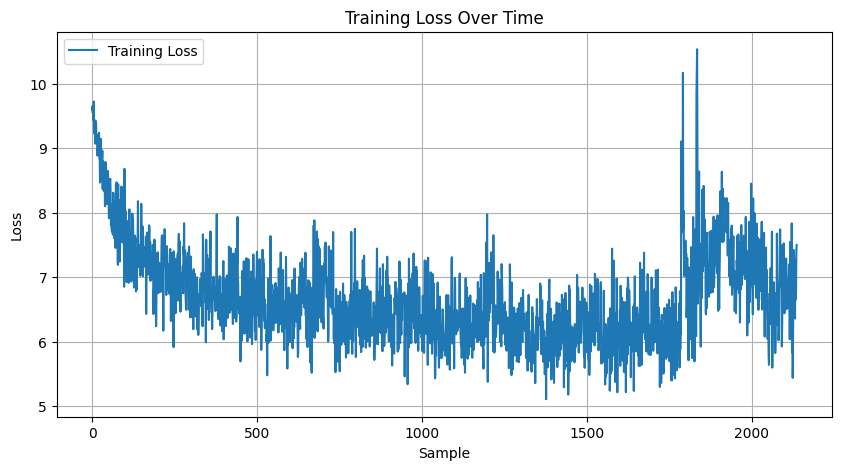

Training complete.
Sample 0, Loss: 9.591355323791504
Sample 1, Loss: 9.654656410217285
Sample 2, Loss: 9.543050765991211
Sample 3, Loss: 9.572022438049316
Sample 4, Loss: 9.43367862701416
Sample 5, Loss: 9.724903106689453
Sample 6, Loss: 9.238914489746094
Sample 7, Loss: 9.231557846069336
Sample 8, Loss: 9.360930442810059
Sample 9, Loss: 9.071181297302246
Sample 10, Loss: 9.431304931640625
Sample 11, Loss: 9.339807510375977
Sample 12, Loss: 9.38710880279541
Sample 13, Loss: 9.151346206665039
Sample 14, Loss: 9.213957786560059
Sample 15, Loss: 9.074017524719238
Sample 16, Loss: 8.886363983154297
Sample 17, Loss: 8.990160942077637
Sample 18, Loss: 8.949640274047852
Sample 19, Loss: 9.141629219055176
Sample 20, Loss: 9.007793426513672
Sample 21, Loss: 9.239517211914062
Sample 22, Loss: 8.837249755859375
Sample 23, Loss: 8.816926002502441
Sample 24, Loss: 8.467703819274902
Sample 25, Loss: 9.016532897949219
Sample 26, Loss: 8.905939102172852
Sample 27, Loss: 9.14438533782959
Sample 28, Los

In [24]:
def main():
    # Initialize GPT configuration
    gpt_config = GPTConfig()
    
    # Initialize the Transformer model with the configuration
    gpt_model = Transformer(gpt_config)

    # Set up the optimizer with the model parameters and learning rate
    optimizer = optim.Adam(gpt_model.parameters(), lr=1e-4)

    # Define the path to the training data folder
    training_data_folder = Path("./training_data")
    
    # Get the training data from the specified folder
    some_book = get_training_data_from_folder(training_data_folder)
    
    # Initialize the Trainer with the model, training data, optimizer, and training parameters
    trainer = Trainer(gpt_model, some_book, optimizer, epochs=1, sample_size=50, print_interval=100)

    print("Starting training...")
    
    # Train the model and get the trained model and training records
    trained_model, training_records = trainer.train()

    # Output the training records (losses)
    print("Training complete.")
    for record in training_records:
        print(f"Sample {record['sample']}, Loss: {record['loss']}")

    print("**" * 50)
    
    # Save the trained model to a file
    torch.save(trained_model, "model.pt")

    # Generate text with the trained model using a prompt
    prompt = "Today I plan to complete the following tasks, "
    generated_text = trainer.generate(prompt)

    print("Generated text:")
    print(generated_text)

if __name__ == "__main__":
    main()